# Summary
The goal of this project is to create the best MLP model that accurately predicts Titanic survivors based on their attributes, then enter the results into the Titanic Kaggle competition https://www.kaggle.com/competitions/titanic/overview

A unique feature of this project is the usage of nested hyper-tuners(Grid Search of Bayesian Optimizer parameters) to optimize model hyperparameters

# Importing

In [1]:
!pip install -q -U keras-tuner

from random import randint
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy import stats
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import initializers
seed = 1234
tf.random.set_seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.6 MB/s eta 0:00:00


In [2]:
#@title
def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    if hasattr(history, 'history_'):
      history = history.history_
    else:
      history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sn.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sn.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

# Data Cleaning

In [3]:
test_df = pd.read_csv('test.csv')
#test_df.isna().sum()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
test_df = pd.read_csv('test.csv')
test_df.drop("Name",axis=1,inplace=True)
test_df.drop("Ticket",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Embarked",axis=1,inplace=True)
print(test_df.head())

test_df['Sex'].replace(['female', 'male'],[1,0], inplace=True)

for i in test_df.columns[1:]: 
    test_df[i] = test_df[i]/test_df[i].abs().max() 

test_samples = test_df[["Pclass","Sex","Age","SibSp","Parch","Fare"]].to_numpy()


   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare
0          892       3    male  34.5      0      0   7.8292
1          893       3  female  47.0      1      0   7.0000
2          894       2    male  62.0      0      0   9.6875
3          895       3    male  27.0      0      0   8.6625
4          896       3  female  22.0      1      1  12.2875


In [5]:
#more on data https://www.kaggle.com/competitions/titanic/data

df = pd.read_csv('train.csv') 
df.drop("Name",axis=1,inplace=True)
df.drop("Ticket",axis=1,inplace=True)
df.drop("Cabin",axis=1,inplace=True)
df.drop("Embarked",axis=1,inplace=True)
df = df[['Survived', 'PassengerId', 'Pclass', 'Sex', "Age", 'SibSp', 'Parch', 'Fare']]
df

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,1,3,male,22.0,1,0,7.2500
1,1,2,1,female,38.0,1,0,71.2833
2,1,3,3,female,26.0,0,0,7.9250
3,1,4,1,female,35.0,1,0,53.1000
4,0,5,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
886,0,887,2,male,27.0,0,0,13.0000
887,1,888,1,female,19.0,0,0,30.0000
888,0,889,3,female,NaN,1,2,23.4500
889,1,890,1,male,26.0,0,0,30.0000


In [6]:
#drop duplicates, handling missing data https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/
df.isna().sum()
df = df.dropna(axis=0)
df = df.drop_duplicates()

In [7]:
#M/F --> 0/1
df['Sex'].replace(['female', 'male'],[1,0], inplace=True)
#delete outliers > 3 Z-Score
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [8]:
for i in df.columns[1:]: #skip PassengerId
    df[i] = df[i]/df[i].abs().max() #use abs() before max() because loudness has negative values
df

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,0.001122,1.000000,0.0,0.309859,0.333333,0.0,0.043975
1,1,0.002245,0.333333,1.0,0.535211,0.333333,0.0,0.432369
2,1,0.003367,1.000000,1.0,0.366197,0.000000,0.0,0.048069
3,1,0.004489,0.333333,1.0,0.492958,0.333333,0.0,0.322078
4,0,0.005612,1.000000,0.0,0.492958,0.000000,0.0,0.048827
...,...,...,...,...,...,...,...,...
884,0,0.993266,1.000000,0.0,0.352113,0.000000,0.0,0.042762
886,0,0.995511,0.666667,0.0,0.380282,0.000000,0.0,0.078852
887,1,0.996633,0.333333,1.0,0.267606,0.000000,0.0,0.181965
889,1,0.998878,0.333333,0.0,0.366197,0.000000,0.0,0.181965


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 1, 'Survived'),
  Text(1.5, 1, 'PassengerId'),
  Text(2.5, 1, 'Pclass'),
  Text(3.5, 1, 'Sex'),
  Text(4.5, 1, 'Age'),
  Text(5.5, 1, 'SibSp'),
  Text(6.5, 1, 'Parch'),
  Text(7.5, 1, 'Fare')])

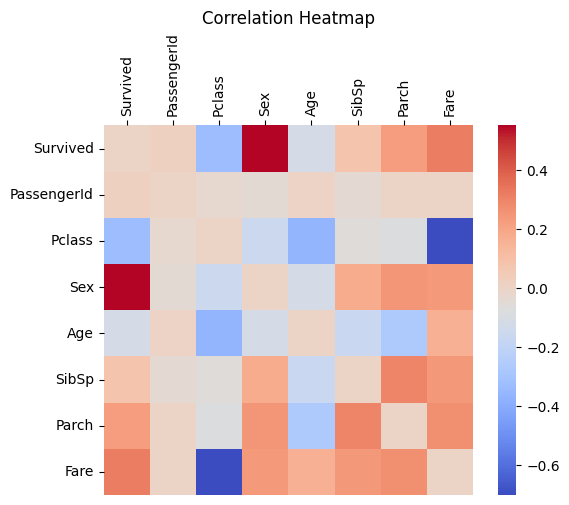

In [9]:
#"For linear models (e.g., linear regression or logistic regression), multicolinearity can yield wildly unstable solutions."

clean_corr = df.corr()#replace 1s with 0s, avoid converting binary audio_mode
for i in clean_corr.columns:
  clean_corr[i][i] = 0
CorrHeat = sn.heatmap(data = clean_corr, cmap='coolwarm', square=True)
CorrHeat.set_title("Correlation Heatmap")
CorrHeat.xaxis.tick_top()
plt.xticks(rotation=90)

In [11]:
# age_train_samples = df[["Pclass","Sex","SibSp","Parch","Fare","Survived"]]
# age_test_samples = df[["Age"]]

# model = Sequential([
#     Dense(units = 6, input_shape=(6,), activation = "relu", use_bias = True, bias_initializer='zeros'),  # first hidden layer , initialize bias as zeroes
#     Dense(units = 6, activation = "relu", use_bias=True, bias_initializer="zeros"),                   # second hidden layer, no need for input shape cause knows 4 output in previous
#     Dense(units = 1, activation = "relu") 
# ])

# model.compile(optimizer = SGD(learning_rate = 0.03), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x=train_samples, y=train_labels, validation_split=0.1, batch_size = 30, epochs = 100, shuffle = True, verbose = 2, callbacks=[stop_early]) #take 10% to test data
# plot_acc(history)

# predictions = model.predict(x=test_samples)     # Run our points through our best model
# rounded_predictions = np.argmax(predictions, axis = 1)   # Pick the high prob in each prediction 

# submission = pd.DataFrame()
# submission["PassengerID"] = test_df["PassengerId"]
# submission["Survived"] = pd.DataFrame(rounded_predictions)
# submission.to_csv("sean_kickass_submission18.csv", index = False)

In [13]:
train_samples = df[["Pclass","Sex","SibSp","Age","Parch","Fare"]].to_numpy() 
train_labels = df[["Survived"]].to_numpy()
print(train_samples.shape)
print(train_labels.shape)
#print(train_samples)
#print(train_labels)
#print(len(train_samples[0]))

(657, 6)
(657, 1)


#Keras Tuner

In [20]:
def model_builder(hp): 
  model = keras.Sequential()
  model.add(keras.Input(shape=(6,)))
  model.add(keras.layers.Dense(units = hp.Int('layer1', min_value=2, max_value=8, step = 2), activation = "relu", use_bias=True, bias_initializer="zeros"))
  model.add(keras.layers.Dropout(rate = hp.Float('dropout1', min_value=0.05, max_value=0.25, step = 0.05)))
  model.add(keras.layers.Dense(units = hp.Int('layer2', min_value=2, max_value=8, step = 2), activation = "relu", use_bias=True, bias_initializer="zeros"))
  model.add(keras.layers.Dropout(rate = hp.Float('dropout2', min_value=0.05, max_value=0.25, step = 0.05)))
  model.add(keras.layers.Dense(units = 2, activation= "softmax"))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.01, max_value=0.01, step = 0.01)),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [21]:
# def bay_builder(hp):
#   tuner.search(x=train_samples, y=train_labels, validation_split=0.2, batch_size = 12, epochs = 25, shuffle = False, verbose = 2, callbacks=[stop_early]) 

In [22]:
tuner = kt.BayesianOptimization(hypermodel = model_builder,
                     objective='val_accuracy',
                     #max_epochs=20,
                     #factor=3,
                     #directory='my_dir',
                     #project_name='hyper-tuning3'
                      overwrite=True,
                      max_trials = 20
                      )
# bay_tuner = kt.BayesianOptimization(hypermodel = bay_builder,
#                      objective='val_accuracy',
#                      #max_epochs=20,
#                      #factor=3,
#                      #directory='my_dir',
#                      #project_name='hyper-tuning3'
#                       overwrite=True
#                       )

In [23]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [29]:
# for validation_split in range(10)/30:
#   for batch_size in range(5,50,5):
#     for epochs in range(10,200,10):
tuner.search(x=train_samples, y=train_labels, validation_split=0.2, batch_size = 12, epochs = 25, shuffle = False, verbose = 2, callbacks=[stop_early]) #epochs don't matter here cause we're tuning epochs later anyways. Original is Shuffle = True

In [25]:
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.values)

tuner.results_summary()

{'layer1': 8, 'dropout1': 0.25, 'layer2': 2, 'dropout2': 0.2, 'learning_rate': 0.01}
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
layer1: 8
dropout1: 0.25
layer2: 2
dropout2: 0.2
learning_rate: 0.01
Score: 0.8636363744735718

Trial 12 summary
Hyperparameters:
layer1: 8
dropout1: 0.1
layer2: 2
dropout2: 0.2
learning_rate: 0.01
Score: 0.8560606241226196

Trial 19 summary
Hyperparameters:
layer1: 8
dropout1: 0.25
layer2: 6
dropout2: 0.1
learning_rate: 0.01
Score: 0.8560606241226196

Trial 18 summary
Hyperparameters:
layer1: 8
dropout1: 0.1
layer2: 6
dropout2: 0.15000000000000002
learning_rate: 0.01
Score: 0.8409090638160706

Trial 00 summary
Hyperparameters:
layer1: 6
dropout1: 0.15000000000000002
layer2: 8
dropout2: 0.25
learning_rate: 0.01
Score: 0.8333333134651184

Trial 16 summary
Hyperparameters:
layer1: 6
dropout1: 0.2
layer2: 6
dropout2: 0.25
learning_rate: 0.01
Score: 0.83333

# Recreating Best Model

In [26]:
model = tuner.hypermodel.build(best_hp) 

model.summary()
history = model.fit(x=train_samples, y=train_labels, validation_split=0.2, batch_size = 12, epochs = 25, shuffle = False, verbose = 2, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 56        
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 2)                 18        
                                                                 
 dropout_3 (Dropout)         (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 2)                 6         
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
44/44 - 1s - loss: 0.6787 - accuracy: 0.5905 - 

In [30]:
# Retrain model with best epoch, submit
# hypermodel = model_builder(best_hp)
# history = hypermodel.fit(x=train_samples, y=train_labels, validation_split=0.1, batch_size = 30, epochs = best_epoch, shuffle = True, verbose = 2)

predictions = model.predict(x=test_samples)     # Run our points through our best model
rounded_predictions = np.argmax(predictions, axis = 1)   # Pick the high prob in each prediction 
print(f"{predictions=}")
# rounded_predictions = np.rint(predictions) #for binary cross
# print(f"{rounded_predictions=}") #for binary cross

submission = pd.DataFrame()
submission["PassengerID"] = test_df["PassengerId"]
submission["Survived"] = pd.DataFrame(rounded_predictions)
submission.to_csv("sean_kickass_submission.csv", index = False)

14/14 [==============================] - 0s 2ms/step
predictions=array([[0.6194598 , 0.38054022],
       [0.39804372, 0.60195625],
       [0.54813963, 0.45186043],
       [0.6065794 , 0.3934206 ],
       [0.32972753, 0.67027247],
       [0.5842265 , 0.41577354],
       [0.3274418 , 0.6725582 ],
       [0.5358599 , 0.46414015],
       [0.30540103, 0.694599  ],
       [0.7130883 , 0.28691176],
       [       nan,        nan],
       [0.41767755, 0.5823225 ],
       [0.2889601 , 0.71103984],
       [0.5791892 , 0.42081085],
       [0.2889601 , 0.71103984],
       [0.2889601 , 0.71103984],
       [0.5022888 , 0.49771115],
       [0.59691936, 0.4030806 ],
       [0.36072248, 0.63927746],
       [0.36116642, 0.6388336 ],
       [0.44941708, 0.5505829 ],
       [0.55481267, 0.44518736],
       [       nan,        nan],
       [0.33286515, 0.6671348 ],
       [0.2889601 , 0.71103984],
       [0.6837515 , 0.31624845],
       [0.2889601 , 0.71103984],
       [0.5994701 , 0.40052986],
       [0.4